# AutoEncoder
I emulated the security camera from youtube video [LIVE NYC's Times Square!, | Usa , | world famous street-level camera | World Live Streams](https://www.youtube.com/watch?v=SbsxuwwAiDI&t)
create a dataset of images and try to encode this dataset into small file and after that can be reconstructed like the first source

# Preparation

### Import, constants and functions

In [ ]:
import numpy as np
from numpy.random import seed
#seed(12345)

import cv2
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model, Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

from google.colab import drive
from google.colab.patches import cv2_imshow

In [ ]:
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [ ]:
def show_results(history):
  # Show training history (this cell is complete, nothing to implement here :-) )
  h = history.history
  epochs = range(len(h['loss']))

  plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
  plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
  plt.legend(['Train', 'Validation'])
  plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                            epochs, h['val_accuracy'], '.-')
  plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
  plt.legend(['Train', 'Validation'])

  print('Train Acc     ', h['accuracy'][-1])
  print('Validation Acc', h['val_accuracy'][-1])

In [ ]:
def comparison(test_dataset, decoded_imgs, n):
  for ii in range(n):
      image_num = np.random.randint(0, len(test_dataset))

      plt.subplot(2,n,ii+1), plt.imshow(test_dataset[image_num, ...])
      plt.title("original")

      plt.subplot(2,n,ii+1+n), plt.imshow(decoded_imgs[image_num, ...])
      plt.title("reconstructed")    

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

### Data inspaction

In [ ]:
# Load data from the folder
with open('drive/MyDrive/Colab Notebooks/StreetCamera_Data_XX/train_dataset.npy', 'rb') as f:
    train_dataset = np.load(f)

with open('drive/MyDrive/Colab Notebooks/StreetCamera_Data_XX/test_dataset.npy', 'rb') as f:
    test_dataset = np.load(f)

hight = train_dataset.shape[1]
width = train_dataset.shape[2]

In [ ]:
print('Train set:   ', len(train_dataset), 'samples')
print('Test set:    ', len(test_dataset), 'samples')
print('Sample dims: ', train_dataset.shape)

Train set:    17243 samples
Test set:     4311 samples
Sample dims:  (17243, 128, 192, 3)


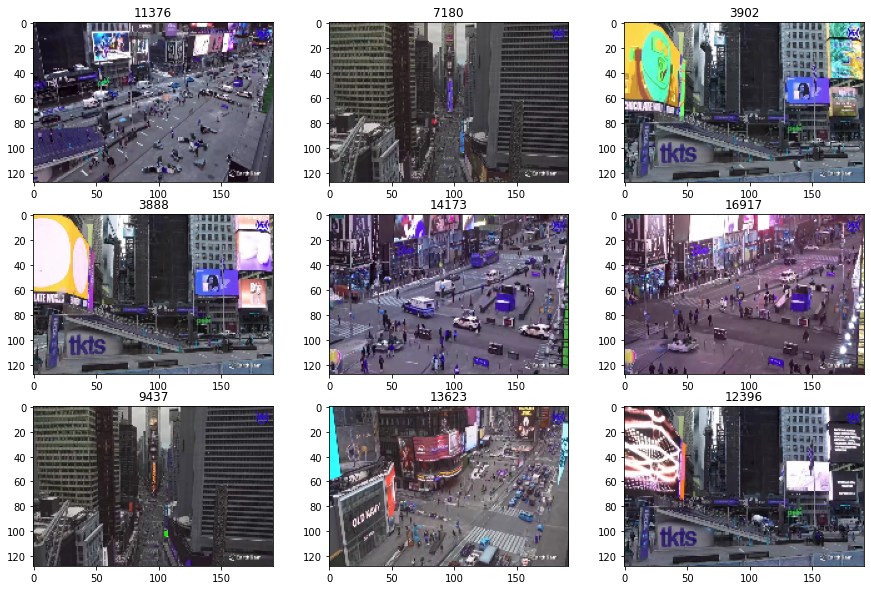

In [ ]:
# Show random samples
for ii in range(9):
    image_num = np.random.randint(0, len(train_dataset))
    plt.subplot(3,3,ii+1), plt.imshow(train_dataset[image_num, ...])
    plt.title(str(image_num))

#Building model

In [ ]:
# Normalization
train_dataset = train_dataset.astype('float32')/255
test_dataset = test_dataset.astype('float32')/255

## Model

###Creating

In [ ]:
latent_dim = 1000



#encoder============================================
inputs = layers.Input(shape=(hight, width, 3))

net = inputs

# loop over the number of filters
for f in (64, 128, 256):
  # apply a CONV => RELU => BN => Dropout operation
  net = layers.Conv2D(f, (3, 3),strides=2, padding="same")(net)
  net = layers.LeakyReLU(alpha=0.3)(net)
  net = layers.BatchNormalization(axis=-1)(net)
  net = layers.Dropout(0.1)(net)  

latentSize = K.int_shape(net)
net = layers.Flatten()(net)
latent = layers.Dense(latent_dim, activation='relu')(net)

encoder = Model(inputs, latent, name="encoder")




#decoder============================================
latentInputs = layers.Input(latent_dim)
net = layers.Dense(np.prod(latentSize[1:]))(latentInputs)
net = layers.Reshape((latentSize[1], latentSize[2], latentSize[3]))(net)

# loop over our number of filters again, but this time in
# reverse order
for f in (256, 128, 64):
  # apply a CONV_TRANSPOSE => RELU => BN => Dropout operation
  net = layers.Conv2DTranspose(f, (3, 3), strides=2, padding="same")(net)  
  net = layers.LeakyReLU(alpha=0.3)(net)
  net = layers.BatchNormalization(axis=-1)(net)
  net = layers.Dropout(0.1)(net)

net = layers.Conv2DTranspose(3, (3, 3), padding="same")(net)
outputs = layers.Activation("sigmoid")(net)

decoder = Model(latentInputs, outputs, name="decoder")



#autoencoder============================================
autoencoder = Model(inputs, decoder(encoder(inputs)),
            name="autoencoder")

###Summary

In [ ]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 128, 192, 3)]     0         
                                                                 
 conv2d_30 (Conv2D)          (None, 64, 96, 64)        1792      
                                                                 
 leaky_re_lu_60 (LeakyReLU)  (None, 64, 96, 64)        0         
                                                                 
 batch_normalization_60 (Bat  (None, 64, 96, 64)       256       
 chNormalization)                                                
                                                                 
 dropout_36 (Dropout)        (None, 64, 96, 64)        0         
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 48, 128)       73856     
                                                           

In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 1000)]            0         
                                                                 
 dense_21 (Dense)            (None, 98304)             98402304  
                                                                 
 reshape_10 (Reshape)        (None, 16, 24, 256)       0         
                                                                 
 conv2d_transpose_40 (Conv2D  (None, 32, 48, 256)      590080    
 Transpose)                                                      
                                                                 
 leaky_re_lu_63 (LeakyReLU)  (None, 32, 48, 256)       0         
                                                                 
 batch_normalization_63 (Bat  (None, 32, 48, 256)      1024      
 chNormalization)                                          

In [ ]:
autoencoder.compile(optimizer='adam', loss=MeanSquaredError(), metrics=["accuracy"])

###Fit

In [ ]:
epochs = 100
batch_size = 64
history = autoencoder.fit(DataGenerator(train_dataset, train_dataset, batch_size),
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(DataGenerator(test_dataset, test_dataset, batch_size)))

Epoch 1/100
270/270 [==============================] - 23s 80ms/step - loss: 0.0358 - accuracy: 0.5736 - val_loss: 0.0291 - val_accuracy: 0.6363
Epoch 2/100
270/270 [==============================] - 21s 79ms/step - loss: 0.0213 - accuracy: 0.6105 - val_loss: 0.0157 - val_accuracy: 0.6820
Epoch 3/100
270/270 [==============================] - 21s 79ms/step - loss: 0.0143 - accuracy: 0.6374 - val_loss: 0.0119 - val_accuracy: 0.6565
Epoch 4/100
270/270 [==============================] - 21s 79ms/step - loss: 0.0110 - accuracy: 0.6621 - val_loss: 0.0117 - val_accuracy: 0.6999
Epoch 5/100
270/270 [==============================] - 21s 79ms/step - loss: 0.0095 - accuracy: 0.6773 - val_loss: 0.0098 - val_accuracy: 0.7174
Epoch 6/100
270/270 [==============================] - 21s 79ms/step - loss: 0.0086 - accuracy: 0.6888 - val_loss: 0.0088 - val_accuracy: 0.6882
Epoch 7/100
270/270 [==============================] - 21s 79ms/step - loss: 0.0078 - accuracy: 0.6986 - val_loss: 0.0074 - val_ac

In [ ]:
show_results(history)

In [ ]:
# Save the entire model as a SavedModel.
encoder.save('drive/MyDrive/Colab Notebooks/encoder')
decoder.save('drive/MyDrive/Colab Notebooks/decoder')

###Result inspaction

In [ ]:
#encoder = tf.keras.models.load_model('drive/MyDrive/Colab Notebooks/encoder')
#decoder = tf.keras.models.load_model('drive/MyDrive/Colab Notebooks/decoder')

In [ ]:
check_dataset = test_dataset[:500,...]

encoded_imgs = encoder(check_dataset).numpy()
decoded_imgs = decoder(encoded_imgs).numpy()

with open('drive/MyDrive/Colab Notebooks/StreetCamera_Data_XX/encoded_imgs.npy', 'wb') as f:
    np.save(f, encoded_imgs)

with open('drive/MyDrive/Colab Notebooks/StreetCamera_Data_XX/check_dataset.npy', 'wb') as f:
    np.save(f, check_dataset)

In [ ]:
print('Sample encoded: ', encoded_imgs.shape)
print('Sample decoded: ', decoded_imgs.shape)
print('comression: ', decoded_imgs.shape[1]*decoded_imgs.shape[2]*decoded_imgs.shape[3]/encoded_imgs.shape[1])

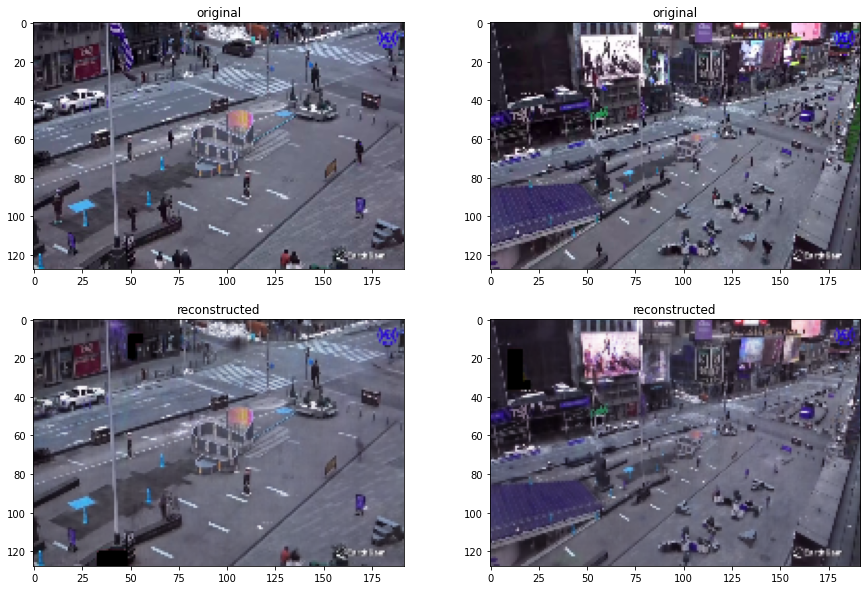

In [ ]:
# Show random comparison
comparison(check_dataset, decoded_imgs, 2)

Sample dims:  (1, 128, 192, 3)


Text(0.5, 1.0, 'reconstructed')

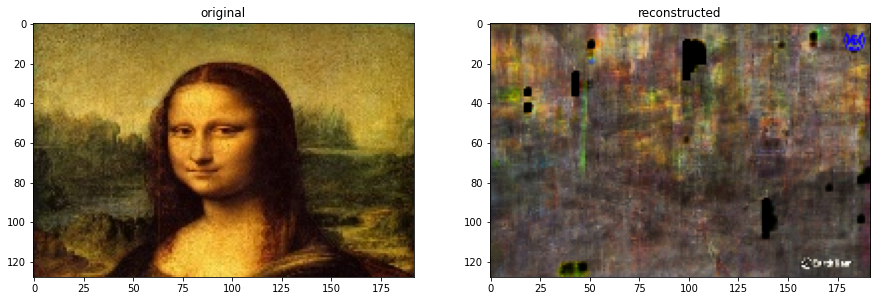

In [ ]:
control_Img = cv2.imread('drive/MyDrive/Colab Notebooks/StreetCamera_Data_XX/monolisa.jpg')
control_Img = cv2.cvtColor(control_Img, cv2.COLOR_BGR2RGB)
control_Imgs = np.array([control_Img])

print('Sample dims: ', control_Imgs.shape)

control_Imgs = control_Imgs.astype('float32')/255

control_encoded_imgs = encoder(control_Imgs).numpy()
control_decoded_imgs = decoder(control_encoded_imgs).numpy()

plt.subplot(1,2,1), plt.imshow(control_Imgs[0])
plt.title("original")

plt.subplot(1,2,2), plt.imshow(control_decoded_imgs[0])
plt.title("reconstructed")   